In [1]:
import torch

# 檢查是否有可用的GPU
if torch.cuda.is_available():
    device = torch.device("cuda")  # 使用GPU
    print("GPU is available")
else:
    device = torch.device("cpu")  # 使用CPU
    print("GPU not available, CPU used")


GPU is available


In [2]:
from gensim.models import KeyedVectors

# 載入預訓練 FastText 模型
fasttext_model = KeyedVectors.load_word2vec_format(r'C:\Users\UJay\School\judgement_classfier\models\fine_tuned_fasttext.vec', binary=False)

# 獲取單詞向量
# vector = fasttext_model['性騷擾']
# print("Vector for 'Paris':", vector)

# 找出最相似的城市單詞
# similar_cities = fasttext_model.most_similar('巴黎', topn=5)
# print("Cities most similar to 'Paris':", similar_cities)


## 建立資料集類別與分類

In [3]:
import os
import re
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import BertForSequenceClassification, BertTokenizer, AdamW
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report
import torch.nn.functional as F
# 載入BERT斷詞器
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

# 定義文本分類數據集
class CustomDataset(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = labels

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
        return {'text': text, 'label': self.labels[idx]}

# 資料夾路徑和類別
categories = ['Abuse', 'Drug', 'Sex_assault', 'Economic_assault', 'Others']

# 收集所有文本檔案路徑和對應標籤
train_labels = []
train_file_paths = []

valid_labels = []
valid_file_paths = []

test_labels = []
test_file_paths = []

base_path = r'C:\Users\UJay\School\judgement_classfier\ProcessedDatasets'
for i, category in enumerate(categories):
    category_folder_path = os.path.join(base_path, category)
    file_names = sorted(os.listdir(category_folder_path), key=lambda x: int(re.findall(r'\d+', x)[0]))
    
    # 總文件數
    total_files = len(file_names)

    # 計算訓練、驗證和測試的文件數
    num_train_files = 500 if i>1 else 400
    num_valid_files = 350 if i>1 else 300
    num_test_files = total_files - num_train_files - num_valid_files
    end_index = num_train_files + num_valid_files
    end_index = end_index+200 if i!=1 else len(file_names) 
    # 根據計算的文件數，將文件名列表分為訓練、驗證和測試三部分
    train_file_names = file_names[:num_train_files]
    valid_file_names = file_names[num_train_files:num_train_files + num_valid_files]
    test_file_names = file_names[num_train_files + num_valid_files:end_index]

    for file_name in train_file_names:
        train_file_paths.append(os.path.join(category_folder_path, file_name))
        one_hot_label = F.one_hot(torch.tensor(i), num_classes=5)
        train_labels.append(one_hot_label)

    for file_name in valid_file_names:
        valid_file_paths.append(os.path.join(category_folder_path, file_name))
        one_hot_label = F.one_hot(torch.tensor(i), num_classes=5)
        valid_labels.append(one_hot_label)

    for file_name in test_file_names:
        test_file_paths.append(os.path.join(category_folder_path, file_name))
        one_hot_label = F.one_hot(torch.tensor(i), num_classes=5)
        test_labels.append(one_hot_label)

train_dataset = CustomDataset(train_file_paths, train_labels)
valid_dataset = CustomDataset(valid_file_paths, valid_labels)
test_dataset = CustomDataset(test_file_paths, test_labels)

c:\Users\UJay\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 處理文本並儲存，將Datasets中所有的文本處理過後儲存在ProcessedDatasets

In [4]:
import os
import re
import jieba
from gensim.models import FastText
from gensim.models.keyedvectors import KeyedVectors
import numpy as np

def load_words(file_path):
    """從指定文件加载词语"""
    with open(file_path, 'r', encoding='utf-8') as file:
        words = file.read().splitlines()
    return set(words)

def load_custom_dict(file_path):
    """從指定文件載入自定義字典"""
    custom_dict = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            word = line.strip()
            custom_dict[word] = 1  # 將所有詞的頻率設置為 1，或者你也可以設置為其他值
    return custom_dict

def preprocess_text(text, skip_words):
    """去除skip_words中的詞"""
    pattern = '|'.join(map(re.escape, skip_words))
    processed_text = re.sub(pattern, '', text)
    return processed_text

def process_files_in_directory(input_dir, output_dir, skip_file, custom_dict_file, categories):
    """處理输入目錄中的所有文件，並將處理過後的文件保存在輸出目錄"""
    skip_words = load_words(skip_file)
    # stop_words = load_words(stopwords_file)
    # all_skip_words = skip_words.union(stop_words)
    custom_dict = load_custom_dict(custom_dict_file)
    
    # 加载自定義字典到 jieba
    for word, freq in custom_dict.items():
        jieba.add_word(word, freq=freq)
    
    processed_texts = []

    for category in categories:
        category_path = os.path.join(input_dir, category)
        for root, dirs, files in os.walk(category_path):
            for file in files:
                if file.endswith('.txt'):
                    input_file_path = os.path.join(root, file)
                    with open(input_file_path, 'r', encoding='utf-8') as f:
                        text = f.read()

                    processed_text = preprocess_text(text, skip_words)
                    
                    # 斷詞並移除停用詞
                    words = jieba.cut(processed_text)
                    processed_words = [word for word in words if word not in skip_words]
                    processed_texts.append(processed_words)
                    
                    # 路徑
                    relative_path = os.path.relpath(root, input_dir)
                    output_file_dir = os.path.join(output_dir, relative_path)
                    os.makedirs(output_file_dir, exist_ok=True)
                    output_file_path = os.path.join(output_file_dir, file)

                    # 保存處理後的文本
                    with open(output_file_path, 'w', encoding='utf-8') as f:
                        f.write(' '.join(processed_words))
    
    # # 測試
    # with open('processed_texts.txt', 'w', encoding='utf-8') as f:
    #     for text in processed_texts:
    #         f.write(' '.join(text) + '\n')
    
    # print("Processed texts have been saved to 'processed_texts.txt'.")

# 示例使用
input_directory = r'C:\Users\UJay\School\judgement_classfier\Datasets'  # 原始数据所在目录
output_directory = r'C:\Users\UJay\School\judgement_classfier\ProcessedDatasets'  # 处理后的数据保存目录
skip_words_file = r'C:\Users\UJay\School\judgement_classfier\Custom dictionary\skip.txt'  # 包含要跳过词语的文件
custom_dict_file = r'C:\Users\UJay\School\judgement_classfier\Custom dictionary\dict.txt'  # 自定义字典文件

categories = ['Abuse', 'Drug', 'Sex_assault', 'Economic_assault', 'Others']  # 类别文件夹列表
# 需要處理原始數據，再使用以下程式碼
# process_files_in_directory(input_directory, output_directory, skip_words_file, custom_dict_file, categories)

# print("Finished processing files.")

---

Fasttext微調(用來文字轉向量)

In [5]:
from gensim.models import FastText
from gensim.models.keyedvectors import KeyedVectors
# 讀取處理後的文本
processed_texts = []
with open(r'C:\Users\UJay\School\judgement_classfier\models\processed_texts.txt', 'r', encoding='utf-8') as f:
    for line in f:
        processed_texts.append(line.strip().split())

# 加載預訓練 FastText 模型
pretrained_model_path = r'C:\Users\UJay\School\judgement_classfier\models\wiki.zh.vec'
fasttext_model = KeyedVectors.load_word2vec_format(pretrained_model_path, binary=False)

# 初始化新的 FastText 模型
model_fasttext = FastText(vector_size=300)

# 構建詞彙表
model_fasttext.build_vocab([list(fasttext_model.key_to_index.keys())] + processed_texts)

# 將預訓練的詞向量賦值給新的模型
model_fasttext.wv.vectors = fasttext_model.vectors

# 進行微調
model_fasttext.train(processed_texts, total_examples=model_fasttext.corpus_count, epochs=model_fasttext.epochs)

print("Model has been fine-tuned and trained.")

KeyboardInterrupt: 

In [5]:
model_fasttext.wv.save_word2vec_format('fine_tuned_fasttext.vec', binary=False)

In [7]:
model_fasttext.save('fine_tuned_fasttext.model')

載入已訓練之文字轉向量模型

In [6]:
# from gensim.models import FastText
from gensim.models.keyedvectors import KeyedVectors

model_fasttext_file = r'C:\Users\UJay\School\judgement_classfier\models\fine_tuned_fasttext.vec'
model_fasttext = KeyedVectors.load_word2vec_format(model_fasttext_file, binary=False)

In [7]:
import numpy as np
import jieba

def text_to_vector(text, max_length=300):
    # skip_words = load_words(skip_file)
    words = jieba.cut(text)
    processed_words = [word for word in words]
    
    # 將詞向量轉換為numpy array
    vectors = [model_fasttext[word] for word in processed_words if word in model_fasttext]
    
    # 如果向量數目小於 max_length，進行填充
    if len(vectors) < max_length:
        vectors.extend([np.zeros(model_fasttext.vector_size)] * (max_length - len(vectors)))
    else:
        vectors = vectors[:max_length]  # 截斷過長的向量
    
    return np.array(vectors)


In [61]:
print(text_to_vector('性騷擾'))
print(text_to_vector('性騷擾').shape)

[[-2.72254205 -0.07244187  1.29851437 ... -0.15342955  2.13823795
   0.72757548]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(300, 300)


In [8]:
train_dataset.file_paths[-5:], train_dataset.labels[-5:]

(['C:\\Users\\UJay\\School\\judgement_classfier\\ProcessedDatasets\\Others\\496.txt',
  'C:\\Users\\UJay\\School\\judgement_classfier\\ProcessedDatasets\\Others\\497.txt',
  'C:\\Users\\UJay\\School\\judgement_classfier\\ProcessedDatasets\\Others\\498.txt',
  'C:\\Users\\UJay\\School\\judgement_classfier\\ProcessedDatasets\\Others\\499.txt',
  'C:\\Users\\UJay\\School\\judgement_classfier\\ProcessedDatasets\\Others\\500.txt'],
 [tensor([0, 0, 0, 0, 1]),
  tensor([0, 0, 0, 0, 1]),
  tensor([0, 0, 0, 0, 1]),
  tensor([0, 0, 0, 0, 1]),
  tensor([0, 0, 0, 0, 1])])

對文章測試負採樣

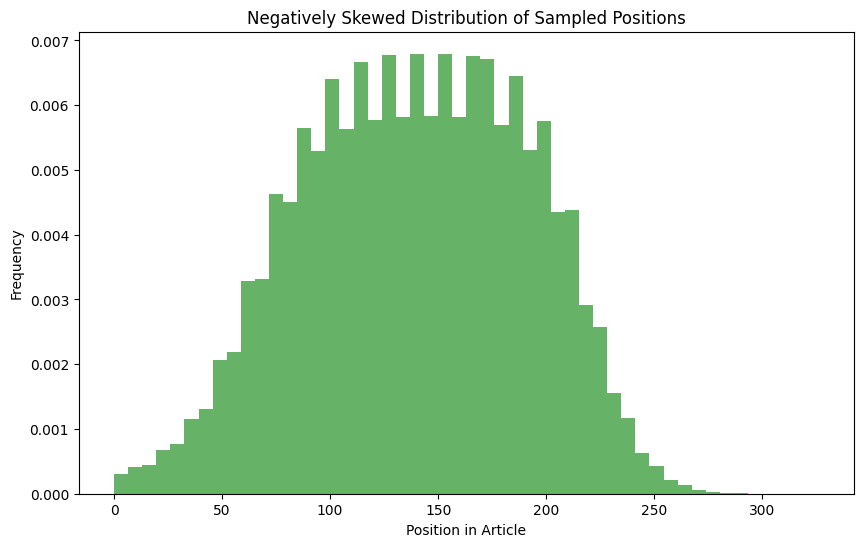

Epoch: 0
['高 法院 刑事 判決 111 更 164 \xa0   訴 \xa0   \xa0   \xa0   被 \xa0   告 \xa0   黃 承駿 列訴 被告 妨害 秩序 不服 新竹 地方法院 110762 華 111 年 1 月 25 日 審判決 新竹 地方 檢察署 110 少連 43 訴判決 最高法院 撤銷 發回 更 審 1114664 判決 \xa0   \xa0   主 \xa0   文 撤銷 黃 承駿 犯意 圖供 用 攜帶 兇器 公共 場 聚集 首謀手 實施 強暴 罪期 徒刑 陸月 易科罰金 新 臺 幣 壹仟 元 折算 壹日 扣案 木棍 貳 支 沒收 \xa0 \xa0   \xa0   事 \xa0   實黃承駿 前 吳家 真實 姓名 年籍 詳卷 92 年 7 月 生證據 證明 黃 承駿 知悉 案發 12 歲 滿 18 歲 少年 債務 糾紛 遂 110 年 2 月 4 日 21 許 首倡 議 邀集 王修賢 楊仕新 曾 宇昊 郭子揚 犯意 圖供 用 攜帶 兇器 公共 場 聚集 手實施 強暴 〈 王修賢 〉 施強 暴助勢 〈 楊仕新 曾 宇昊 郭子揚 〉 罪原 審 判罪 刑確定 少年 徐權 92 年 2 月 16 日生涉 妨害 秩序 事件 新竹 地方法院 少年法庭 110 少 167 裁定 訓誡 併 假日 生活 輔導 要求 曾宇昊 聯 繫 友 吳 益 93 年 5 月 15 日生涉 妨害 秩序 事件 新竹 地方法院 少年法庭 111 少 35 裁定 令入 感化 教育 施 感化 教育 邱 94 年 4 月 5 日生涉 妨害 秩序 事件 新竹 地方法院 少年法庭 110 少 389 裁定 令入 感化 教育 施 感化 教育 徐權 吳益 邱真實 姓名 年籍 詳卷 證據 證明 黃 承駿 知悉 案發 12 歲 滿 18 歲 少 年 同 前往 新竹市 區路 0 段 00 文化 心演 藝廳 前 停車場 聚眾 尋釁 詎 黃 承駿 王修賢 楊仕新 曾 宇昊 郭子揚 徐權 吳益 邱 明知 案發 地點 公共 場意 圖 施暴 此 聚集 將公眾 對 公共秩序 信賴產 生動搖 仍 意圖 施暴 基 公共 場 聚集 施強 暴 犯意 聯絡 同日 2115 許開 地點 黃 承駿王 修賢持 木棒 毆 打 吳家 傷害 據 告訴 手 實施 強暴 另 楊仕新 曾 宇昊 郭子揚 徐權

In [9]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer
import numpy as np
import matplotlib.pyplot as plt

# train_dataset = CustomDataset(train_file_paths, train_labels) # 使用上面的train_dataset
loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')  # 加載BERT tokenizer

def negatively_skewed_sample_indices(total_length, max_length=512):
    mean = total_length // 2  # 均值設為文章位置
    std_dev = total_length // 6  # 标准差设为文章长度的1/6

    indices = []
    while len(indices) < max_length and len(indices) < total_length:
        # 生成负偏态分布的索引值
        index = int(np.random.normal(loc=mean, scale=std_dev))
        if index < 0:
            index = -index  # 将负数转换为正数
        index = int(index ** 0.8)  # 调整指数幂以实现负偏态分布
        if index < total_length:
            indices.append(index)
    indices = sorted(set(indices))  # 去重并排序
    return indices

# 生成取樣位置的數據并繪製分布圖
total_length = 1000  # 假設文章長度为1000
num_samples = 10000  # 生成10000次取樣位置數據
all_sampled_indices = []

for _ in range(num_samples):
    indices = negatively_skewed_sample_indices(total_length)
    all_sampled_indices.extend(indices)

# 畫圖(測試用)
plt.figure(figsize=(10, 6))
plt.hist(all_sampled_indices, bins=50, density=True, alpha=0.6, color='g')
plt.title('Negatively Skewed Distribution of Sampled Positions')
plt.xlabel('Position in Article')
plt.ylabel('Frequency')
plt.show()

# 實際使用中對文章進行負偏態分布採樣
def negatively_skewed_sample(words, max_length=512):
    total_length = len(words)
    indices = negatively_skewed_sample_indices(total_length, max_length)
    sampled_words = [words[i] for i in indices]
    return ' '.join(sampled_words)

for epoch in range(1):
    print('Epoch:', epoch)
    for i, data in enumerate(loader):
        text_list = data['text']
        label_list = data['label']

        # 對文章進行負偏態分布採樣
        sampled_text_list = [negatively_skewed_sample(text.split()) for text in text_list]
        print(text_list)
        print(sampled_text_list)

        # 使用tokenizer对取樣後的文本進行編碼
        encoded_inputs = tokenizer(sampled_text_list, return_tensors='pt', padding=True, truncation=True)
        
        print(encoded_inputs.input_ids.shape)
        print(label_list)
        
        # 将標籤轉換為LongTensor
        labels_tensor = torch.LongTensor(label_list)
        print(labels_tensor)
        
        break  # 測試一個batch


定義文章轉向量函數

In [38]:
import jieba
import numpy as np
import re
import torch
from gensim.models import FastText
from gensim.models.keyedvectors import KeyedVectors

jieba.load_userdict(r'C:\Users\UJay\School\judgement_classfier\Custom dictionary\dict.txt')
skip_words = load_words(skip_words_file)

# def text_to_vector(text, max_length=300):
#     # skip_words = load_words(skip_file)
#     words = jieba.cut(text)
#     processed_words = [word for word in words]
    
#     # 將詞向量轉換為numpy array
#     vectors = [model_fasttext.wv[word] for word in processed_words if word in model_fasttext.wv]
    
#     # 如果向量數目小於 max_length，進行填充
#     if len(vectors) < max_length:
#         vectors.extend([np.zeros(model_fasttext.vector_size)] * (max_length - len(vectors)))
#     else:
#         vectors = vectors[:max_length]  # 截斷過長的向量
    
#     return np.array(vectors)

def preProcessText_and_getVector(texts, max_length=300, skip_words=skip_words):
    all_vectors = []
    not_in_model = []
    in_models = []
    for text in texts:
        text = re.sub(' +', '', text.strip())# 去除空白
        text = re.sub(r'[^\u4e00-\u9fa5]', '', text) # 去除非中文字符(會讓文字都連在一起)
        words = jieba.cut(text,cut_all=False)

        words = [word for word in words if word not in skip_words]
        # 以下可以選擇是否要進行負偏態取樣
        # words = negatively_skewed_sample(words)
        
        # 將詞向量轉換為numpy array
        vectors = [model_fasttext[word] for word in words if word in model_fasttext]
        in_models.append([word for word in words if word in model_fasttext])
        not_in = [word for word in words if word not in model_fasttext]
        # 如果向量數目小於 max_length，進行填充
        if len(vectors) < max_length:
            vectors.extend([np.zeros(model_fasttext.vector_size)] * (max_length - len(vectors)))
        else:
            vectors = vectors[:max_length]  # 截斷過長的向量
        all_vectors.append(vectors)
        not_in_model.append(not_in)
    return np.array(all_vectors), not_in_model, in_models

In [63]:
jieba.load_userdict(r'C:\Users\UJay\School\judgement_classfier\Custom dictionary\dict.txt')
for data in DataLoader(train_dataset, batch_size=1, shuffle=True):
    text = data['text']
    label = data['label']
    print(text)
    print(text[0].strip())
    text = re.sub(' +', '', text[0].strip())
    print(text)
    text = re.sub(r'[^\u4e00-\u9fa5]', '', text)
    print("簡單的處理文字:",text)
    words = jieba.cut(text,cut_all=False)
    words_for_search = jieba.cut_for_search(text)
    skip_words = load_words(skip_words_file)
    print("需要跳過的字典:",skip_words)
    words = [word for word in words if word not in skip_words]
    words_for_search = [word for word in words_for_search if word not in skip_words]
    print("處理過後的文本:",words)
    print(len(words))
    print("處理過後的文本(搜尋):",words_for_search)
    print(len(words_for_search))
    # final_result = negatively_skewed_sample(words)
    # print("最終結果:",final_result)
    # print(len(final_result.split()))
    print(label)
    # print("1:",text_to_vector(final_result.split()[0]))
    # print("2:",text_to_vector(final_result.split()[0]).shape)
    # print("3:",text_to_vector(' '.join(words)))
    # print("4:",text_to_vector(final_result).shape)
    arr, not_in,in_model = preProcessText_and_getVector([text])
    print("5:",arr)
    print("6:",arr.shape)
    print("7:",not_in)
    print("8:",len(not_in[0]))
    print("9:",in_model)
    print("10:",len(in_model[0]))
    break

['高 法院 刑事 判決 110180 \xa0   訴 \xa0   \xa0   新北 地方 檢察署 檢察官 \xa0   訴 \xa0   \xa0   \xa0   被 \xa0   告 \xa0   潘秉鈞 \xa0   \xa0   \xa0   \xa0   \xa0   \xa0   \xa0   \xa0   \xa0   \xa0   另案 法務部 執選任 辯護 \xa0   楊東 鎮律 師法 扶律 師列訴 兒童 少年 性剝削 防制 例 不服 新北 地方法院 109144 華 110 年 3 月 31 日 審判 決新北 地方 檢察署 10925290 訴判決 \xa0   \xa0   主 \xa0   文 附表 編 2 定 執刑 撤銷 犯 違反 本意 願 方法 少年 被 拍 攝 猥褻 電子 訊 罪期 徒刑 柒年 貳 月 扣案 附表 編 1 示手 機同 附表 編 2 數位 影像 電子 訊 沒收 他 訴駁 回開 撤銷 改判 訴駁 回 附表 編 1 刑執期 徒刑 柒年 肆 月 \xa0   \xa0   犯罪 事實 成年 109 年 6 月 19 日午 8 許新北市 土城 區 裕民 路 92 巷 25 弄口 見少 年 192 年 9 月 生案 發 16 歲代 D000 - 109291 真實 姓名 年籍 詳卷 身穿 高級 工業 職業 學校 運動服 校名 詳卷 稱 高工 運動服 知悉 1 滿 18 歲 少 年 仍 對 1 佯稱 自己 運動 品牌 調員欲 拍 攝 青少年 身形 照片 做調 1 不疑 他 便 隨同 前往 同市 區路 00 巷 00 弄 0 夾 娃娃 機店 內 附表 編 1 示手機 表示 要 拍 攝內 褲待 1 脫運動 褲竟 意圖 性騷擾 乘 1 不 抗拒 際 突手觸 摸 1 生殖器 1 將手 撥開 表示 拒絕 此知 1 不願 此類 方式 身體 接觸 竟 提 昇 對 少年 強制 猥褻 犯意 這 工作 不顧 1 拒絕 違 反意 願將手 伸入 內褲 裏 撫 摸 1 生殖器 對 1 強制 猥褻 逞 109 年 5 月 29 日午 758 許新北 市區 0 出口 附近 巷子 裡面 見 291 年 12 月 生案 發 17 歲代 D000 - Z000000000 真實 姓名 年籍 詳卷 身穿 高工 運動服 知悉 2 可能 滿 18 歲 少 年 仍 對

In [77]:
print(data['text'])
vectors,not_in,in_model = preProcessText_and_getVector(data['text'],max_length=300)
# model2()

print(vectors.shape)
print(not_in)
print(in_model)
vectors = torch.tensor(vectors).float().to(device)
print(vectors.shape)
print(data['label'])
print(model2(vectors).softmax(dim=1))

['高 法院 刑事 判決 110180 \xa0   訴 \xa0   \xa0   新北 地方 檢察署 檢察官 \xa0   訴 \xa0   \xa0   \xa0   被 \xa0   告 \xa0   潘秉鈞 \xa0   \xa0   \xa0   \xa0   \xa0   \xa0   \xa0   \xa0   \xa0   \xa0   另案 法務部 執選任 辯護 \xa0   楊東 鎮律 師法 扶律 師列訴 兒童 少年 性剝削 防制 例 不服 新北 地方法院 109144 華 110 年 3 月 31 日 審判 決新北 地方 檢察署 10925290 訴判決 \xa0   \xa0   主 \xa0   文 附表 編 2 定 執刑 撤銷 犯 違反 本意 願 方法 少年 被 拍 攝 猥褻 電子 訊 罪期 徒刑 柒年 貳 月 扣案 附表 編 1 示手 機同 附表 編 2 數位 影像 電子 訊 沒收 他 訴駁 回開 撤銷 改判 訴駁 回 附表 編 1 刑執期 徒刑 柒年 肆 月 \xa0   \xa0   犯罪 事實 成年 109 年 6 月 19 日午 8 許新北市 土城 區 裕民 路 92 巷 25 弄口 見少 年 192 年 9 月 生案 發 16 歲代 D000 - 109291 真實 姓名 年籍 詳卷 身穿 高級 工業 職業 學校 運動服 校名 詳卷 稱 高工 運動服 知悉 1 滿 18 歲 少 年 仍 對 1 佯稱 自己 運動 品牌 調員欲 拍 攝 青少年 身形 照片 做調 1 不疑 他 便 隨同 前往 同市 區路 00 巷 00 弄 0 夾 娃娃 機店 內 附表 編 1 示手機 表示 要 拍 攝內 褲待 1 脫運動 褲竟 意圖 性騷擾 乘 1 不 抗拒 際 突手觸 摸 1 生殖器 1 將手 撥開 表示 拒絕 此知 1 不願 此類 方式 身體 接觸 竟 提 昇 對 少年 強制 猥褻 犯意 這 工作 不顧 1 拒絕 違 反意 願將手 伸入 內褲 裏 撫 摸 1 生殖器 對 1 強制 猥褻 逞 109 年 5 月 29 日午 758 許新北 市區 0 出口 附近 巷子 裡面 見 291 年 12 月 生案 發 17 歲代 D000 - Z000000000 真實 姓名 年籍 詳卷 身穿 高工 運動服 知悉 2 可能 滿 18 歲 少 年 仍 對

In [106]:
# model_fasttext['陰囊']
similar_words = fasttext_model.most_similar('陰囊', topn=5)
# similar_words
words = in_model[0]
# 去除words重複的詞
words = list(set(words))
vectors = [fasttext_model[word] for word in words]
similarities = fasttext_model.cosine_similarities(fasttext_model['性'], vectors)
for i,word in enumerate(words):
    if similarities[i] > 0.3:
        print(word)
        print(similarities[i])
# print(similarities)

感
0.34019807
此性
0.4669345
性
1.0000001
性交
0.34055382
不性
0.33976305
制性
0.56342584
別性
0.34298566
壓制性
0.5299592


訓練與驗證、測試集之數量圖表

Label: [400, 400, 500, 500, 500]


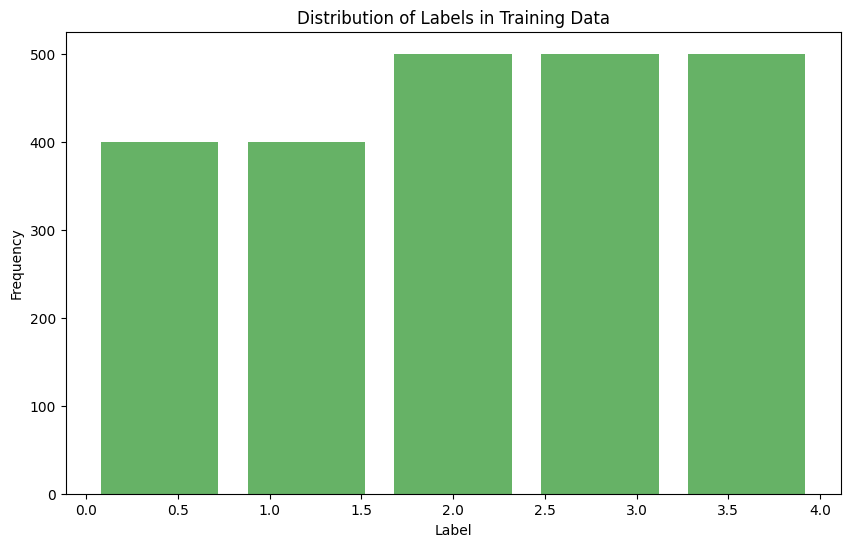

Label: [300, 300, 350, 350, 350]


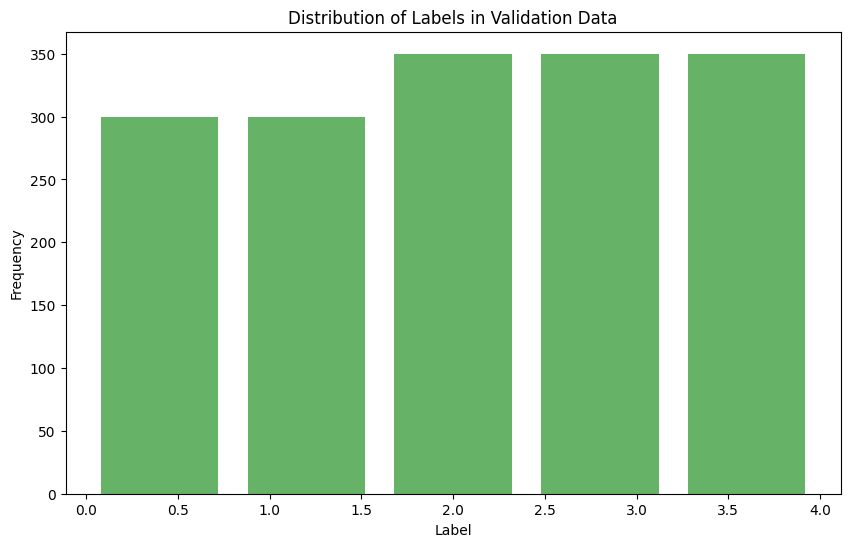

Label: [200, 181, 200, 200, 200]


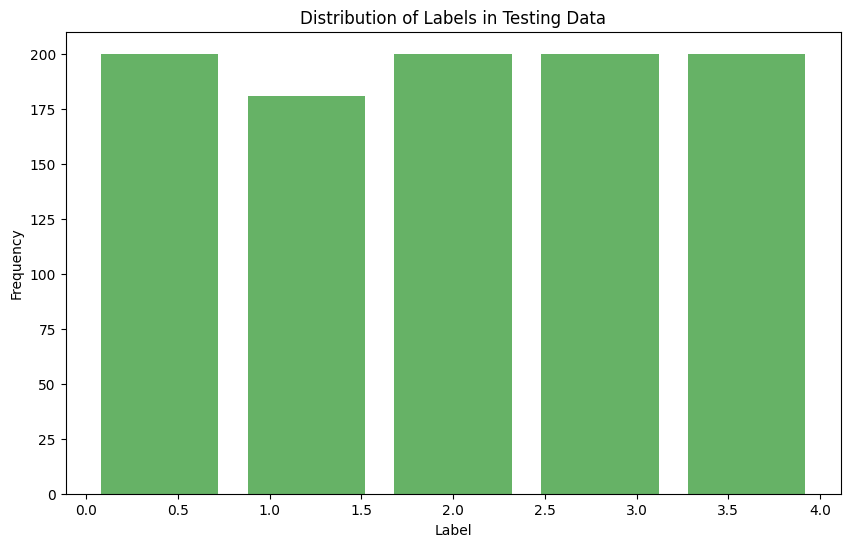

In [11]:
import matplotlib.pyplot as plt

def plot_label_distribution(dataset, title):
    labels_distribution = []
    label_nums = [0, 0, 0, 0, 0]
    for i, data in enumerate(DataLoader(dataset, batch_size=1, shuffle=True)):
        idx = data['label'].argmax().item()
        labels_distribution.append(idx)
        label_nums[idx] += 1
    # 印出標籤分佈
    print('Label:', label_nums)
    plt.figure(figsize=(10, 6))
    plt.hist(labels_distribution, bins=5, density=False, alpha=0.6, color='g', rwidth=0.8)
    plt.title(title)
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.show()

# 繪製訓練數據集的標籤分佈
plot_label_distribution(train_dataset, 'Distribution of Labels in Training Data')

# 繪製驗證數據集的標籤分佈
plot_label_distribution(valid_dataset, 'Distribution of Labels in Validation Data')


# 繪製測試數據集的標籤分佈
plot_label_distribution(test_dataset, 'Distribution of Labels in Testing Data')

定義NN模型(已改為載入預訓練模型)

In [12]:
from torch import nn

# vocab_size = 21128
embed_size = 300
# max_length = 512  
model = nn.Sequential(
    nn.Flatten(start_dim=1),  # 展開層
    nn.Linear(embed_size*300, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(32, 5),
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)
model.load_state_dict(torch.load(r'C:\Users\UJay\School\judgement_classfier\models\DNN.pth'))
# # 假設你有一個輸入向量
# input_vector = torch.randn(1, 300)
# input_vector = input_vector.to(device)
# # 將輸入向量傳遞給模型
# output = model(input_vector)
# print(output)
# 輸出應該是一個長度為5的 softmax 向量
# print(nn.Softmax(dim=1)(output))

cuda


<All keys matched successfully>

訓練NN模型

In [45]:
# 訓練參數
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True)

# 定義優化器和損失函數
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()
epochs = 15
train_losses_per_epoch = []
val_losses_per_epoch = []

# 訓練循環
for epoch in range(epochs):
    print('Epoch:', epoch)
    model.train()
    train_losses = []
    val_losses = []
    for i, data in enumerate(tqdm(loader)):
        try:
            # 將文本數據轉換為模型可以接受的輸入格式
            sampled_text_list = [negatively_skewed_sample(text.split()) for text in data['text']]
            # train_inputs = tokenizer(sampled_text_list, return_tensors='pt', padding=True, truncation=True, max_length=max_length).input_ids
            # vector = text_to_vector(sampled_text_list)  # 將文本轉換為向量
            # vectors = [text_to_vector(text) for text in sampled_text_list]
            vectors = preProcessText_and_getVector(sampled_text_list,max_length=300)
            # vectors = torch.tensor(vectors, dtype=torch.float32)
            train_inputs = torch.tensor(vectors, dtype=torch.float32)

            # train_inputs = torch.tensor([vector],dtype=torch.float32)  # 將向量轉換為 PyTorch 張量
            # train_inputs = train_inputs.reshape(-1, 300)
            
            # 獲取標籤
            train_labels = torch.tensor(data['label'],dtype=torch.float32).float()

            # 確保輸入數據形狀正確
            # assert train_inputs.shape[1] == max_length, f"Unexpected input shape: {train_inputs.shape}"

            # 將輸入數據移動到指定的設備上
            train_inputs = train_inputs.to(device)
            train_labels = train_labels.to(device)

            # 將參數梯度設為零
            optimizer.zero_grad()

            # 前向傳播 + 反向傳播 + 優化
            outputs = model(train_inputs)
            loss = criterion(outputs, train_labels)
            loss.backward()
            optimizer.step()

            # 畫圖用
            train_losses.append(loss.item())
        except Exception as e:
            print(f"Error at epoch {epoch}, batch {i}: {e}")
            print(f"train_inputs shape: {train_inputs.shape}")
            print(f"train_labels shape: {train_labels.shape}")
            continue

    avg_train_loss = sum(train_losses) / len(train_losses)
    train_losses_per_epoch.append(avg_train_loss)

    # 驗證循環
    model.eval()  # 設置模型為評估模式
    with torch.no_grad():
        for i, data in enumerate(tqdm(val_loader)):
            try:
                sampled_text_list = [negatively_skewed_sample(text.split()) for text in data['text']]
                # val_inputs = tokenizer(sampled_text_list, return_tensors='pt', padding=True, truncation=True, max_length=max_length).input_ids
                
                # vector = text_to_vector(sampled_text_list)  # 將文本轉換為向量
                # vectors = [text_to_vector(text) for text in sampled_text_list]
                vectors = preProcessText_and_getVector(sampled_text_list,max_length=300)
                # vectors = torch.tensor(vectors, dtype=torch.float32)
                val_inputs = torch.tensor(vectors, dtype=torch.float32)
                # val_inputs = val_inputs.reshape(-1, 300)
                
                val_labels = torch.tensor(data['label'],dtype=torch.float32).float()

                # 確保輸入數據形狀正確
                # assert val_inputs.shape[1] == max_length, f"Unexpected input shape: {val_inputs.shape}"

                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)

                outputs = model(val_inputs)
                loss = criterion(outputs, val_labels)

                # 保存驗證損失
                val_losses.append(loss.item())
            except Exception as e:
                print(f"Error at epoch {epoch}, batch {i}: {e}")
                print(f"val_inputs shape: {val_inputs.shape}")
                print(f"val_labels shape: {val_labels.shape}")
                continue

        avg_val_loss = sum(val_losses) / len(val_losses)
        val_losses_per_epoch.append(avg_val_loss)

print('Finished Training')

Epoch: 0


  0%|          | 0/144 [00:00<?, ?it/s]C:\Users\UJay\AppData\Local\Temp\ipykernel_11184\607668078.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(data['label'],dtype=torch.float32).float()
  0%|          | 0/104 [00:00<?, ?it/s]C:\Users\UJay\AppData\Local\Temp\ipykernel_11184\607668078.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels = torch.tensor(data['label'],dtype=torch.float32).float()
100%|██████████| 104/104 [00:11<00:00,  8.96it/s]


Epoch: 1


100%|██████████| 104/104 [00:11<00:00,  8.88it/s]


Epoch: 2


100%|██████████| 104/104 [00:12<00:00,  8.66it/s]


Epoch: 3


100%|██████████| 104/104 [00:12<00:00,  8.56it/s]


Epoch: 4


100%|██████████| 104/104 [00:12<00:00,  8.63it/s]


Epoch: 5


100%|██████████| 104/104 [00:12<00:00,  8.61it/s]


Epoch: 6


100%|██████████| 104/104 [00:12<00:00,  8.60it/s]


Epoch: 7


100%|██████████| 104/104 [00:12<00:00,  8.54it/s]


Epoch: 8


100%|██████████| 104/104 [00:12<00:00,  8.52it/s]


Epoch: 9


100%|██████████| 104/104 [00:12<00:00,  8.55it/s]


Epoch: 10


100%|██████████| 104/104 [00:11<00:00,  8.70it/s]


Epoch: 11


100%|██████████| 104/104 [00:11<00:00,  8.72it/s]


Epoch: 12


100%|██████████| 104/104 [00:11<00:00,  8.85it/s]


Epoch: 13


100%|██████████| 104/104 [00:11<00:00,  8.71it/s]


Epoch: 14


100%|██████████| 104/104 [00:11<00:00,  8.78it/s]

Finished Training


In [83]:
from torch.optim import RMSprop
loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True)

# 定義優化器和損失函數
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
epochs = 1
train_losses = []
val_losses = []
# 訓練循環
for epoch in range(epochs):
    print('Epoch:', epoch)
    model.train()
    for i, data in enumerate(tqdm(loader)):
        # 將文本數據轉換為模型可以接受的輸入格式
        train_inputs = tokenizer(data['text'], return_tensors='pt', padding=True, truncation=True).input_ids

        # 獲取標籤
        train_labels = data['label'].float()

        train_inputs = train_inputs.to(device)  # 將輸入數據移動到指定的設備上
        train_labels = train_labels.to(device)  # 將標籤數據移動到指定的設備上

        # 將參數梯度設為零
        optimizer.zero_grad()

        # 前向傳播 + 反向傳播 + 優化
        outputs = model(train_inputs)
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()
        
        # 畫圖用
        train_losses.append(loss.item())
        # 打印統計信息
        # if (i+1) % 100 == 0:
        #     print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(loader)}], Loss: {loss.item()}')
    # 驗證循環
    model.eval()  # 設置模型為評估模式
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            val_inputs = tokenizer(data['text'], return_tensors='pt', padding=True, truncation=True).input_ids.float()
            val_labels = data['label'].float()

            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)

            outputs = model(val_inputs)
            loss = criterion(outputs, val_labels)

            # 保存驗證損失
            val_losses.append(loss.item())
print('Finished Training')

Epoch: 0


  1%|          | 2/364 [00:00<02:15,  2.67it/s]


KeyboardInterrupt: 

觀察訓練狀況

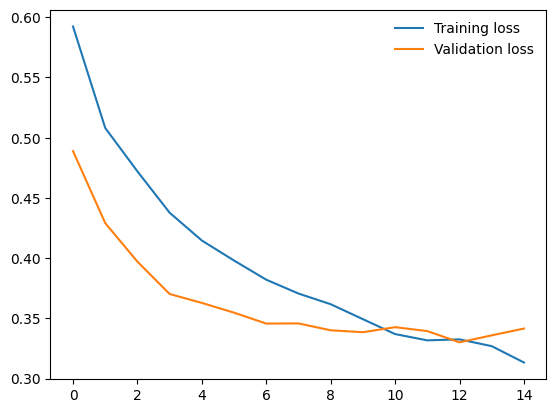

In [46]:
import matplotlib.pyplot as plt

# 繪製NN訓練和驗證損失圖
plt.plot(train_losses_per_epoch, label='Training loss')
plt.plot(val_losses_per_epoch, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [144]:
# 儲存模型
torch.save(model.state_dict(), 'DNN.pth')

---
定義CNN模型(改為載入預訓練模型)

In [13]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from tqdm import tqdm

# 模型参数
# vocab_size = tokenizer.vocab_size
embed_size = 300
num_filters = 128
kernel_size = 5
stride = 1
pool_size = 2

class MyModel(nn.Module):
    def __init__(self, embed_size, num_filters, kernel_size, stride, pool_size):
        super(MyModel, self).__init__()
        # self.embedding = nn.Embedding(vocab_size, embed_size)
        self.conv = nn.Conv1d(embed_size, num_filters, kernel_size, stride)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(pool_size)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(((300 - kernel_size) // stride + 1) // pool_size * num_filters, 64)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 5)  # 五分類

    def forward(self, x):
        # x = self.embedding(x)
        x = x.permute(0, 2, 1)  # 交換維度
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 初始化模型
model2 = MyModel(embed_size, num_filters, kernel_size, stride, pool_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = model2.to(device)
model2.load_state_dict(torch.load(r'C:\Users\UJay\School\judgement_classfier\models\CNN.pth'))

<All keys matched successfully>

訓練CNN

In [153]:
# 訓練CNN參數
loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

# 定義優化器和損失函數
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-5)
criterion2 = nn.CrossEntropyLoss()  # 使用交叉熵损失函数

epochs2 = 20
train_losses2_per_epoch = []
val_losses2_per_eoch = []

# 訓練循環
for epoch in range(epochs2):
    print('Epoch:', epoch)
    model2.train()
    train_losses2 = []
    val_losses2 = []
    for i, data in enumerate(tqdm(loader)):
        
        # # 对文章进行负偏态分布采样
        sampled_text_list = [negatively_skewed_sample(text.split()) for text in data['text']]
        # 將文本數據轉換為模型可以接受的輸入格式
        vectors = [text_to_vector(text) for text in sampled_text_list]
        # print(data['text'])
        # print("1")
        # vectors,_,_ = preProcessText_and_getVector(data['text'],max_length=300)
        vectors = torch.tensor(vectors, dtype=torch.float32)
        # train_inputs = torch.unsqueeze(torch.tensor(vectors, dtype=torch.float32), 0)
        # print(vectors.shape, vectors.dtype)
        # train_inputs = torch.tensor(vectors, dtype=torch.float32)  # 添加一個新的維度
        
        # train_inputs = tokenizer(sampled_text_list, return_tensors='pt', padding=True, truncation=True).input_ids
        # 將文本數據轉換為模型可以接受的輸入格式
        
        # print(train_inputs.shape, train_inputs.dtype)
        
        # 獲取標籤
        train_labels = torch.argmax(torch.tensor(data['label'], dtype=torch.float32), dim=1)

        vectors = vectors.to(device)  # 將輸入數據移動到指定的設備上
        train_labels = train_labels.to(device)  # 將標籤數據移動到指定的設備上

        # 將參數梯度設為零
        optimizer2.zero_grad()

        # 前向傳播 + 反向傳播 + 優化
        outputs = model2(vectors)
        # print(outputs.shape, outputs.dtype)
        # print(train_labels)
        loss = criterion2(outputs, train_labels)
        loss.backward()
        optimizer2.step()
        train_losses2.append(loss.item())
        # 畫圖用
    avg_train_loss = sum(train_losses2) / len(train_losses2)
    train_losses2_per_epoch.append(avg_train_loss)

    # 驗證循環
    model2.eval()  # 設置模型為評估模式
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            
            # 对文章进行负偏态分布采样
            sampled_text_list = [negatively_skewed_sample(text.split()) for text in data['text']]
            vectors = [text_to_vector(text) for text in sampled_text_list]
            # vectors,_,_ = preProcessText_and_getVector(data['text'],max_length=300)
            vectors = torch.tensor(vectors, dtype=torch.float32)
            # val_inputs = torch.tensor(vectors, dtype=torch.float32)
            # val_inputs = tokenizer(sampled_text_list, return_tensors='pt', padding=True, truncation=True).input_ids
            val_labels = torch.argmax(torch.tensor(data['label'], dtype=torch.float32), dim=1)

            vectors = vectors.to(device)
            val_labels = val_labels.to(device)

            outputs = model2(vectors)
            loss = criterion2(outputs, val_labels)

            # 保存驗證損失
            val_losses2.append(loss.item())
    avg_val_loss = sum(val_losses2) / len(val_losses2)
    val_losses2_per_eoch.append(avg_val_loss)
print('Finished Training')


Epoch: 0


  0%|          | 0/72 [00:00<?, ?it/s]C:\Users\UJay\AppData\Local\Temp\ipykernel_11184\2195195846.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.argmax(torch.tensor(data['label'], dtype=torch.float32), dim=1)
100%|██████████| 72/72 [00:41<00:00,  1.75it/s]
C:\Users\UJay\AppData\Local\Temp\ipykernel_11184\2195195846.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels = torch.argmax(torch.tensor(data['label'], dtype=torch.float32), dim=1)


Epoch: 1


100%|██████████| 72/72 [00:41<00:00,  1.75it/s]


Epoch: 2


100%|██████████| 72/72 [00:41<00:00,  1.73it/s]


Epoch: 3


100%|██████████| 72/72 [00:43<00:00,  1.67it/s]


Epoch: 4


100%|██████████| 72/72 [00:42<00:00,  1.69it/s]


Epoch: 5


100%|██████████| 72/72 [00:42<00:00,  1.69it/s]


Epoch: 6


100%|██████████| 72/72 [00:42<00:00,  1.71it/s]


Epoch: 7


100%|██████████| 72/72 [00:42<00:00,  1.70it/s]


Epoch: 8


100%|██████████| 72/72 [00:42<00:00,  1.69it/s]


Epoch: 9


100%|██████████| 72/72 [00:41<00:00,  1.73it/s]


Epoch: 10


100%|██████████| 72/72 [00:42<00:00,  1.69it/s]


Epoch: 11


100%|██████████| 72/72 [00:41<00:00,  1.73it/s]


Epoch: 12


100%|██████████| 72/72 [00:41<00:00,  1.75it/s]


Epoch: 13


100%|██████████| 72/72 [00:40<00:00,  1.76it/s]


Epoch: 14


100%|██████████| 72/72 [00:40<00:00,  1.76it/s]


Epoch: 15


100%|██████████| 72/72 [00:40<00:00,  1.76it/s]


Epoch: 16


100%|██████████| 72/72 [00:40<00:00,  1.77it/s]


Epoch: 17


100%|██████████| 72/72 [00:40<00:00,  1.77it/s]


Epoch: 18


100%|██████████| 72/72 [00:42<00:00,  1.70it/s]


Epoch: 19


100%|██████████| 72/72 [00:40<00:00,  1.76it/s]


Finished Training


觀察CNN訓練狀況

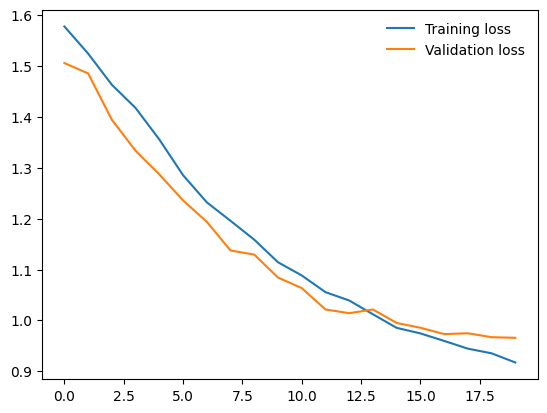

In [154]:
import matplotlib.pyplot as plt

# 繪製訓練和驗證損失圖
plt.plot(train_losses2_per_epoch, label='Training loss')
plt.plot(val_losses2_per_eoch, label='Validation loss')
plt.legend(frameon=False)
plt.show()

定義並訓練LSTM(實驗時效果不彰已移除)

In [134]:
# LSTM
import torch
from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from tqdm import tqdm
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# 假设您已经定义了tokenizer和数据集train_dataset, valid_dataset
# tokenizer = AutoTokenizer.from_pretrained('bert-base-chinese')

# 模型参数
vocab_size = tokenizer.vocab_size
embed_size = 128
hidden_size = 128  # LSTM隐藏层大小
num_layers = 2  # LSTM层数

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, 64)  # 双向LSTM的输出是hidden_size的两倍
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, num_classes)  # 五分类任务

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out.mean(dim=1)  # 取所有时间步的平均值
        # lstm_out = lstm_out[:, -1, :]  # 取最后一个时间步的输出
        x = self.fc1(lstm_out)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 初始化模型
num_classes = 5  # 五分類
model2 = LSTMModel(vocab_size, embed_size, hidden_size, num_layers, num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model2 = model2.to(device)

loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True,drop_last=True)

# 定義優化器和損失函數
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-5)
criterion2 = nn.CrossEntropyLoss()  # 使用交叉熵损失函数

epochs2 = 10
train_losses2_per_epoch = []
val_losses2_per_eoch = []

# 訓練循環
for epoch in range(epochs2):
    print('Epoch:', epoch)
    model2.train()
    train_losses2 = []
    val_losses2 = []
    for i, data in enumerate(tqdm(loader)):
        
        # 对文章进行负偏态分布采样
        sampled_text_list = [negatively_skewed_sample(text.split()) for text in data['text']]
        # 將文本數據轉換為模型可以接受的輸入格式
        train_inputs = tokenizer(sampled_text_list, return_tensors='pt', padding=True, truncation=True).input_ids
        # vectors = preProcessText_and_getVector(data['text'],max_length=300)
        # train_inputs = torch.tensor(vectors, dtype=torch.float32).long()
        # print(train_inputs)
        # print(train_inputs.shape)
        # 獲取標籤
        train_labels = torch.argmax(torch.tensor(data['label'], dtype=torch.float32), dim=1)
        # print(train_labels)
        train_inputs = train_inputs.to(device)  # 將輸入數據移動到指定的設備上
        train_labels = train_labels.to(device)  # 將標籤數據移動到指定的設備上

        # 將參數梯度設為零
        optimizer2.zero_grad()
        # 前向傳播 + 反向傳播 + 優化
        outputs = model2(train_inputs)
        loss = criterion2(outputs, train_labels)
        loss.backward()
        optimizer2.step()
        train_losses2.append(loss.item())

    avg_train_loss = sum(train_losses2) / len(train_losses2)
    train_losses2_per_epoch.append(avg_train_loss)

    # 驗證循環
    model2.eval()  # 設置模型為評估模式
    with torch.no_grad():
        for i, data in enumerate(tqdm(val_loader)):
            
            # 对文章进行负偏态分布采样
            # sampleds_text_list = [negatively_skewed_sample(text.split()) for text in data['text']]
            val_inputs = tokenizer(data['text'], return_tensors='pt', padding=True, truncation=True).input_ids
            val_labels = torch.argmax(torch.tensor(data['label'], dtype=torch.float32), dim=1)
            # vectors = preProcessText_and_getVector(data['text'],max_length=300)
            # val_inputs = torch.tensor(vectors, dtype=torch.float32).long()
            
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            outputs = model2(val_inputs)
            # print(outputs.shape)
            # if outputs.shape!=val_labels.shape:print(outputs.shape,val_labels.shape)
            loss = criterion2(outputs, val_labels)

            # 保存驗證損失
            val_losses2.append(loss.item())
    avg_val_loss = sum(val_losses2) / len(val_losses2)
    val_losses2_per_eoch.append(avg_val_loss)
print('Finished Training')


cuda
Epoch: 0


  0%|          | 0/72 [00:00<?, ?it/s]C:\Users\UJay\AppData\Local\Temp\ipykernel_11184\3421894528.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.argmax(torch.tensor(data['label'], dtype=torch.float32), dim=1)
  0%|          | 0/51 [00:00<?, ?it/s]C:\Users\UJay\AppData\Local\Temp\ipykernel_11184\3421894528.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels = torch.argmax(torch.tensor(data['label'], dtype=torch.float32), dim=1)
100%|██████████| 51/51 [01:09<00:00,  1.37s/it]


Epoch: 1


100%|██████████| 51/51 [01:09<00:00,  1.37s/it]


Epoch: 2


100%|██████████| 51/51 [01:10<00:00,  1.38s/it]


Epoch: 3


100%|██████████| 51/51 [01:08<00:00,  1.35s/it]


Epoch: 4


100%|██████████| 51/51 [01:10<00:00,  1.39s/it]


Epoch: 5


100%|██████████| 51/51 [01:10<00:00,  1.39s/it]


Epoch: 6


100%|██████████| 51/51 [01:10<00:00,  1.38s/it]


Epoch: 7


100%|██████████| 51/51 [01:09<00:00,  1.37s/it]


Epoch: 8


100%|██████████| 51/51 [01:08<00:00,  1.35s/it]


Epoch: 9


100%|██████████| 51/51 [01:10<00:00,  1.38s/it]

Finished Training


---
使用測試集觀察NN模型表現

In [39]:
from sklearn.metrics import classification_report

# 創建測試數據加載器
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

# 將模型設置為評估模式
model.eval()
predicted_labels = []
true_labels = []
# 初始化正確預測的數量和總數量
correct = 0
total = 0

# 不計算梯度，因為我們現在是在進行測試，而不是訓練
with torch.no_grad():
    for i, data in enumerate(test_loader):
        # 將文本數據轉換為模型可以接受的輸入格式
        # sampled_text_list = [negatively_skewed_sample(text.split()) for text in data['text']]
        # inputs = tokenizer(sampled_text_list, return_tensors='pt', padding=True, truncation=True).input_ids
        
        # inputs = inputs.to(device).float()  # 將輸入數據移動到指定的設備上
        vectors = [text_to_vector(text) for text in sampled_text_list]
        inputs = torch.tensor(vectors, dtype=torch.float32)
        inputs = inputs.to(device)
        # 獲取標籤
        labels = torch.argmax(torch.tensor(data['label'], dtype=torch.float), dim=1)

        labels = labels.to(device)  # 將標籤數據移動到指定的設備上
        # 前向傳播
        outputs = model(inputs).softmax(dim=1)
        
        # 獲取預測結果
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        
        # 更新正確預測的數量和總數量
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # if i == 0:
        #     print('Predicted:', predicted)
        #     print('True:', labels)
        #     break
print('Accuracy of the model on the test data: {}%'.format(100 * correct / total))
# 計算並顯示分類報告
report = classification_report(true_labels, predicted_labels)
print(report)

C:\Users\UJay\AppData\Local\Temp\ipykernel_9224\381804537.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.argmax(torch.tensor(data['label'], dtype=torch.float), dim=1)


Accuracy of the model on the test data: 74.5158002038736%
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       200
           1       0.56      0.78      0.65       181
           2       0.89      0.78      0.83       200
           3       0.92      0.80      0.86       200
           4       0.59      0.49      0.54       200

    accuracy                           0.75       981
   macro avg       0.76      0.75      0.75       981
weighted avg       0.76      0.75      0.75       981



In [24]:
from sklearn.metrics import classification_report

# 創建測試數據加載器
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

# 將模型設置為評估模式
model.eval()
predicted_labels = []
true_labels = []
# 初始化正確預測的數量和總數量
correct = 0
total = 0

# 不計算梯度，因為我們現在是在進行測試，而不是訓練
with torch.no_grad():
    for i, data in enumerate(test_loader):
        # 將文本數據轉換為模型可以接受的輸入格式
        # sampled_text_list = [negatively_skewed_sample(text.split()) for text in data['text']]
        # inputs = tokenizer(sampled_text_list, return_tensors='pt', padding=True, truncation=True).input_ids
        
        # inputs = inputs.to(device).float()  # 將輸入數據移動到指定的設備上
        # vectors = [text_to_vector(text) for text in data['text']]
        vectors,_,_ = preProcessText_and_getVector(data['text'],max_length=300)
        inputs = torch.tensor(vectors, dtype=torch.float32)
        inputs = inputs.to(device)
        # 獲取標籤
        labels = torch.argmax(torch.tensor(data['label'], dtype=torch.float), dim=1)

        labels = labels.to(device)  # 將標籤數據移動到指定的設備上
        # 前向傳播
        outputs = model(inputs)
        
        # 獲取預測結果
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        
        # 更新正確預測的數量和總數量
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # if i == 0:
        #     print('Predicted:', predicted)
        #     print('True:', labels)
        #     break
# 打印準確率
print('Accuracy of the model on the test data: {}%'.format(100 * correct / total))
# 計算並打印分類報告
report = classification_report(true_labels, predicted_labels)
print(report)

C:\Users\UJay\AppData\Local\Temp\ipykernel_24096\1263345042.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.argmax(torch.tensor(data['label'], dtype=torch.float), dim=1)


Accuracy of the model on the test data: 71.25382262996942%
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       200
           1       0.57      0.79      0.66       181
           2       0.86      0.71      0.78       200
           3       0.69      0.83      0.75       200
           4       0.60      0.41      0.49       200

    accuracy                           0.71       981
   macro avg       0.72      0.71      0.71       981
weighted avg       0.72      0.71      0.71       981



In [26]:
outputs.shape

torch.Size([85, 5])

使用測試集觀察CNN模型表現

In [27]:
from sklearn.metrics import classification_report
# 創建測試數據加載器
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

# 將模型設置為評估模式
model2.eval()

# 初始化正確預測的數量和總數量
correct = 0
total = 0
predicted_labels = []
true_labels = []
# 不計算梯度，因為我們現在是在進行測試，而不是訓練
with torch.no_grad():
    for i, data in enumerate(tqdm(test_loader)):
        # 將文本數據轉換為模型可以接受的輸入格式
        # sampled_text_list = [negatively_skewed_sample(text.split()) for text in data['text']]
        # inputs = tokenizer(data['text'], return_tensors='pt', padding=True, truncation=True).input_ids
        # vectors,_,_ = preProcessText_and_getVector(data['text'],max_length=300)
        vectors = [text_to_vector(text) for text in data['text']]
        vectors = torch.tensor(vectors, dtype=torch.float32)
        vectors = vectors.to(device)  # 將輸入數據移動到指定的設備上

        # 獲取標籤
        labels = torch.argmax(torch.tensor(data['label'], dtype=torch.float), dim=1)

        labels = labels.to(device)  # 將標籤數據移動到指定的設備上
        # 前向傳播
        outputs = model2(vectors).softmax(dim=1)
        
        # 獲取預測結果
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        # 更新正確預測的數量和總數量
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # if i == 0:
        #     print('Predicted:', predicted)
        #     print('True:', labels)
        #     break
# 打印準確率
print('Accuracy of the model on the test data: {}%'.format(100 * correct / total))
report = classification_report(true_labels, predicted_labels)
print(report)

  0%|          | 0/8 [00:00<?, ?it/s]C:\Users\UJay\AppData\Local\Temp\ipykernel_24096\176463288.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.argmax(torch.tensor(data['label'], dtype=torch.float), dim=1)
100%|██████████| 8/8 [00:48<00:00,  6.07s/it]

Accuracy of the model on the test data: 72.17125382262996%
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       200
           1       0.59      0.78      0.67       181
           2       0.92      0.77      0.83       200
           3       0.62      0.85      0.72       200
           4       0.69      0.34      0.46       200

    accuracy                           0.72       981
   macro avg       0.74      0.72      0.71       981
weighted avg       0.74      0.72      0.71       981



In [29]:
outputs.shape

torch.Size([85, 5])

In [157]:
torch.save(model2.state_dict(), 'CNN.pth')

使用測試集觀察LSTM模型表現

In [142]:
# For LSTM
from sklearn.metrics import classification_report
# 創建測試數據加載器
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

# 將模型設置為評估模式
model2.eval()

# 初始化正確預測的數量和總數量
correct = 0
total = 0
predicted_labels = []
true_labels = []
# 不計算梯度，因為我們現在是在進行測試，而不是訓練
with torch.no_grad():
    for i, data in enumerate(tqdm(test_loader)):
        # 將文本數據轉換為模型可以接受的輸入格式
        # sampled_text_list = [negatively_skewed_sample(text.split()) for text in data['text']]
        inputs = tokenizer(data['text'], return_tensors='pt', padding=True, truncation=True).input_ids
        # vectors,_,_ = preProcessText_and_getVector(sampled_text_list,max_length=300)
        # vectors = torch.tensor(vectors, dtype=torch.float32)
        inputs = inputs.to(device)  # 將輸入數據移動到指定的設備上

        # 獲取標籤
        labels = torch.argmax(torch.tensor(data['label'], dtype=torch.float32), dim=1)

        labels = labels.to(device)  # 將標籤數據移動到指定的設備上
        # 前向傳播
        outputs = model2(inputs)
        
        # 獲取預測結果
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        # 更新正確預測的數量和總數量
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # if i == 0:
        #     print('Predicted:', predicted)
        #     print('True:', labels)
        #     break
# 打印準確率
print('Accuracy of the model on the test data: {}%'.format(100 * correct / total))
report = classification_report(true_labels, predicted_labels)
print(report)

  0%|          | 0/8 [00:00<?, ?it/s]C:\Users\UJay\AppData\Local\Temp\ipykernel_11184\2563293908.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.argmax(torch.tensor(data['label'], dtype=torch.float32), dim=1)
100%|██████████| 8/8 [00:30<00:00,  3.80s/it]

Accuracy of the model on the test data: 20.489296636085626%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       200
           1       0.00      0.00      0.00       181
           2       0.20      0.99      0.34       200
           3       0.00      0.00      0.00       200
           4       0.67      0.01      0.02       200

    accuracy                           0.20       981
   macro avg       0.17      0.20      0.07       981
weighted avg       0.18      0.20      0.07       981




c:\Users\UJay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\UJay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\UJay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

In [15]:
from torch.utils.data import DataLoader

other_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

for i,data in enumerate(other_loader):
    print(data['text'])
    vector = text_to_vector(data['text'])  # 將文本轉換為向量
    inputs = torch.tensor([vector])  # 將向量轉換為 PyTorch 張量
    print(inputs)
    print(inputs.shape)
    print(inputs.max())
    # inputs = tokenizer(data['text'], return_tensors='pt', padding=True, truncation=True).input_ids.float()
    # print(inputs)
    # print(inputs.shape)
    # print(inputs.max())
    # inputs = inputs.to(device)
    # labels = data['label']
    # labels = labels.to(device)
    # outputs = model(inputs).softmax(dim=1)
    # _, predicted = torch.max(outputs.data, 1)
    # _,labels = torch.max(labels.data, 1)
    # print(predicted)
    # print(labels)
    if i == 0:
        # print('Predicted:', predicted)
        # print('True:', labels)
        break

['宜蘭 地方法院 刑事 判決 \u3000 \u3000 \u3000 \u3000 \u3000 \u3000 \u3000 1058 \n \n 公 \u3000 訴 \u3000 \u3000 宜蘭 地方法院 檢察署 檢察官 \n \n 被 \u3000 \u3000 \u3000 告 \u3000 陳 志倫 \n \n 列 被告 妨害性自主 檢察官 賴淑萍 公訴 105   年 \n \n 度 34 嗣 準備 程序 進 被告 被訴 事實 \n \n 罪陳述 裁定 進 簡式 審判 程序 判決 \n \n         主     文 \n \n 十歲 滿十歲 女子 性交共伍 罪 各 \n \n 期 徒刑 肆月 執期 徒刑 壹年 貳 月 \n \n         犯罪 事實 \n \n 103   年 11 月間 透過 臉書 結識 00 年 \n \n         0   月 生真實 姓名 年籍 詳卷 知悉 14 歲 \n \n         滿 16 歲 女子 竟基 14 歲 滿 16 歲 女子 性 交 \n \n         犯意 104 年 6 月旬 起 同年 11 月 1 日間 宜蘭縣 羅 \n \n         東鎮 登園 旅館 宴京 旅館 違 反意 願 情況 \n \n         將陰莖 進入 陰道 方式 性交 5 次 \n \n         \n \n 父真實 姓名 年籍 詳卷訴 宜蘭地 方法 \n \n         院檢察署 檢察官 偵 起訴 \n \n         理     \n \n 簡式 審判 程序 證據 調不受 159   1   限制 \n \n         刑事訴訟法 273   2   定 明文 開簡 \n \n         式 審判 程序 被告 審判陳述 除 \n \n         他作 證據 法定 事具 證據 能力 \n \n         引用 被告 審判陳述 本案 採簡式 審 \n \n         判 程序 他 做 證據 法定 事揆 諸前 揭說明 \n \n         具證據 能力 合先 敘明 \n \n 前 揭 犯罪 事實業 據 被告 偵審理 坦承 不 \n \n         諱 見 偵卷 4   5   卷 2435 核 \n \n         證

C:\Users\UJay\AppData\Local\Temp\ipykernel_9224\1395994950.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  inputs = torch.tensor([vector])  # 將向量轉換為 PyTorch 張量


In [49]:
print(len(tokenizer.vocab))

21128


In [126]:
# import torch
# import torch.nn as nn

# 假設你的詞彙表大小為21128（對於中文的BERT模型），每個詞的嵌入大小為128
vocab_size = 21128
embed_size = 128

# 創建一個嵌入層
embed = nn.Embedding(vocab_size, embed_size)

# 假設你已經有了一些token ID
token_ids = torch.tensor([1, 2, 3, 4, 5])

# 使用嵌入層來轉換token ID
embeddings = embed(token_ids)

# embeddings現在是一個形狀為[5, 128]的張量，其中每一行都是一個token的嵌入向量
print(embeddings.shape)
print(embeddings)

torch.Size([5, 128])
tensor([[ 0.7339,  1.3702,  0.6807, -0.4864,  0.8504, -0.5530,  1.7326, -1.1607,
         -1.4412, -1.0527, -0.4104,  0.3307, -1.1289,  1.7001, -0.1003, -0.2314,
         -1.0625,  0.1697,  2.1540, -1.0863,  1.1437,  1.7524, -1.2595,  0.6025,
          1.3849,  0.4206,  0.7222, -1.1755,  0.3013, -0.2040,  2.4032,  1.8440,
         -0.9664, -2.9424,  0.7980,  0.2737, -1.4733,  0.7540, -0.3898,  0.5760,
          3.4242, -0.0803,  0.5724,  0.6631, -0.1689,  0.3959, -0.6423,  0.3149,
         -1.3659,  0.0506,  0.8063, -0.0652, -2.0170,  0.1905, -1.3762,  0.6896,
         -1.6333,  0.9322,  0.6462,  0.4637, -0.8256, -0.7588,  1.4538,  1.6005,
          0.6780, -0.1324, -0.3781, -3.5438,  0.4424,  0.1547,  0.2300,  0.1654,
         -1.1829,  0.1423, -1.6254, -0.7937, -0.6989,  2.1772,  0.2241,  2.2172,
         -0.6362, -0.7095, -0.1251,  1.0238, -2.2617,  0.3393,  0.4575,  1.6721,
          0.8205,  0.2698,  0.7819,  0.8604,  1.2057,  0.9561, -0.2391, -0.7301,
       

In [168]:
def DNN_predict(model,data_loader):
    model.eval()
    predicted_labels = []
    
    with torch.no_grad():
        for i, data in enumerate(tqdm(data)):
            vectors,_,_ = preProcessText_and_getVector(data,max_length=300)
            inputs = torch.tensor(vectors, dtype=torch.float32)
            inputs = inputs.to(device)
            # 獲取標籤
            labels = torch.argmax(torch.tensor(data['label'], dtype=torch.float), dim=1)

            labels = labels.to(device)  # 將標籤數據移動到指定的設備上
            # 前向傳播
            outputs = model(inputs)
            
            # 獲取預測結果
            _, predicted = torch.max(outputs.data, 1)
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return predicted_labels

In [172]:
# 將test_loader的數據、標籤轉換成列表
test_data = []
test_labels = []
for data in loader:
    test_data.extend(data['text'])
    test_labels.extend(data['label'])
print(test_data)
print(test_labels)
DNN_predict(model,test_data)

In [160]:
def CNN_predict(model,data_loader):
    model.eval()
    predicted_labels = []

    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader)):
            # sampled_text_list = [negatively_skewed_sample(text.split()) for text in data['text']]
            vectors = [text_to_vector(text) for text in sampled_text_list]
            # vectors = preProcessText_and_getVector(sampled_text_list,max_length=300)
            inputs = torch.tensor(vectors, dtype=torch.float32).to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predicted_labels.extend(predicted.cpu().numpy())
    return predicted_labels

In [161]:
CNN_predict(model2,test_loader)

100%|██████████| 8/8 [00:02<00:00,  3.20it/s]


[4,
 3,
 3,
 3,
 1,
 1,
 2,
 0,
 4,
 3,
 1,
 1,
 2,
 0,
 4,
 1,
 4,
 0,
 4,
 3,
 3,
 3,
 1,
 1,
 2,
 0,
 4,
 3,
 1,
 1,
 2,
 0,
 4,
 1,
 4,
 0,
 4,
 3,
 3,
 3,
 1,
 1,
 2,
 0,
 4,
 3,
 1,
 1,
 2,
 0,
 4,
 1,
 4,
 0,
 4,
 3,
 3,
 3,
 1,
 1,
 2,
 0,
 4,
 3,
 1,
 1,
 2,
 0,
 4,
 1,
 4,
 0,
 4,
 3,
 3,
 3,
 1,
 1,
 2,
 0,
 4,
 3,
 1,
 1,
 2,
 0,
 4,
 1,
 4,
 0,
 4,
 3,
 3,
 3,
 1,
 1,
 2,
 0,
 4,
 3,
 1,
 1,
 2,
 0,
 4,
 1,
 4,
 0,
 4,
 3,
 3,
 3,
 1,
 1,
 2,
 0,
 4,
 3,
 1,
 1,
 2,
 0,
 4,
 1,
 4,
 0,
 4,
 3,
 3,
 3,
 1,
 1,
 2,
 0,
 4,
 3,
 1,
 1,
 2,
 0,
 4,
 1,
 4,
 0]

---
載入以訓練之Bert模型

使用測試集觀察Bert模型表現

In [14]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# 模型路徑
model_path = r'C:\Users\UJay\School\judgement_classfier\models\FineTuning_epoch_5\epoch_5'

# BERT tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 載入微調的BERT模型
model_bert = BertForSequenceClassification.from_pretrained(model_path, config=model_path)

# 評估模型
model_bert.eval()
all_predictions = []
all_labels = []
model_bert = model_bert.to(device)
with torch.no_grad():
    for batch in tqdm(DataLoader(test_dataset, batch_size=32, shuffle=False), desc='Evaluating'):
        inputs = tokenizer(batch['text'], return_tensors='pt', padding=True, truncation=True)
        inputs= inputs.to(device)
        labels = torch.tensor(np.argmax(batch['label'], axis=1), dtype=torch.long)
        outputs = model_bert(**inputs)
        predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        all_predictions.extend(predictions)
        all_labels.extend(labels.numpy())
        

# 計算評估指標
accuracy = accuracy_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

# 準確率、召回率和F1分數
print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# 分類報告
report = classification_report(all_labels, all_predictions, target_names=categories)
print('Classification Report:\n', report)


Evaluating:   0%|          | 0/31 [00:00<?, ?it/s]C:\Users\UJay\AppData\Local\Temp\ipykernel_24096\2288324925.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(np.argmax(batch['label'], axis=1), dtype=torch.long)
c:\Users\UJay\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Evaluating: 100%|██████████| 31/31 [00:56<00:00,  1.84s/it]

Accuracy: 0.8491
Recall: 0.8491
F1 Score: 0.8477
Classification Report:
                   precision    recall  f1-score   support

           Abuse       0.97      0.95      0.96       200
            Drug       0.63      0.91      0.75       181
     Sex_assault       0.91      0.96      0.94       200
Economic_assault       0.99      0.86      0.92       200
          Others       0.80      0.56      0.66       200

        accuracy                           0.85       981
       macro avg       0.86      0.85      0.85       981
    weighted avg       0.87      0.85      0.85       981



---
# GA parts:

In [91]:
import numpy as np
from sklearn.metrics import f1_score

def initialize_population(size, num_models, num_features=5):
    population = np.random.dirichlet(np.ones(num_models*num_features), size=size)
    return population.reshape(size, num_models, num_features)


def evaluate_fitness(population, model1, model2, model3, dataloader):
    print("Evaluating fitness...")
    model1_preds = []
    model2_preds = []
    model3_preds = []
    true_labels = []
    model1.eval()
    model2.eval()
    model3.eval()
    for data in tqdm(dataloader):
        inputs = tokenizer(negatively_skewed_sample(data['text']), return_tensors='pt', padding=True, truncation=True)
        inputs= inputs.to(device)
        # labels = torch.tensor(np.argmax(batch['label'], axis=1), dtype=torch.long)
        outputs = model3(**inputs).logits.softmax(dim=1).cpu().detach().numpy()
        # predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        model3_preds.extend(outputs)
        # all_labels.extend(labels.numpy())
        
        vectors = np.array([text_to_vector(text) for text in data['text']])
        vectors = vectors.mean(axis=0)
        inputs = torch.tensor(vectors, dtype=torch.float32).unsqueeze(0).to(device)
        true_labels.extend(data['label'])
        model1_preds.extend(model1(inputs).softmax(dim=1).cpu().detach().numpy())
        model2_preds.extend(model2(inputs).softmax(dim=1).cpu().detach().numpy())
    fitness_scores = []
    for individual in population:
        weights_model1 = individual[0]
        weights_model2 = individual[1]
        weights_model3 = individual[2]

        # 加權平均三個模型的輸出
        ensemble_preds = model1_preds * weights_model1 + model2_preds * weights_model2 + model3_preds * weights_model3
        # 將 ensemble_preds 轉換為類別標籤
        ensemble_preds = np.argmax(ensemble_preds, axis=1)
        # 將預測標籤轉換為與真實標籤相同的形狀
        num_classes = ensemble_preds.max() + 1
        ensemble_preds = np.eye(num_classes)[ensemble_preds]
        # 計算 F1 分數並取負數
        f1 = -f1_score(true_labels, ensemble_preds, average='macro')
        fitness_scores.append(f1)
        
    return np.array(fitness_scores)

# # 假設 model1_preds 和 model2_preds 是模型的輸出
# # y_true 是真實標籤
# model1_preds = np.random.rand(2,5)  # 模擬模型1的輸出
# model2_preds = np.random.rand(2,5)  # 模擬模型2的輸出

# # 生成一個5x5的對角線陣列
# eye_matrix = np.eye(5)

# # 選擇其中一行作為 y_true
# y_true = eye_matrix[2:4]  # 選擇第三行
# print("Model 1 predictions:", model1_preds)
# print("Model 2 predictions:", model2_preds)
# print("True labels:", y_true)
# fitness_scores = evaluate_fitness(population, model, model2, loader)
# print("Fitness scores:")
# print(fitness_scores)

# ======================選擇==================================
def selection(population, fitness_scores):
    print("Selecting...")
    selected_indices = np.argsort(fitness_scores)[:len(population)//2]  # 越小越好，選擇前半部分
    # print(selected_indices)
    return population[selected_indices]

# selected_population = selection(population, fitness_scores)
# print("Selected population:")
# print(selected_population)
# ======================交配==================================
def crossover(parents, num_offspring):
    print("Crossovering...")
    offspring = []
    for _ in range(num_offspring // 2):
        parent1, parent2 = parents[np.random.choice(len(parents), 2, replace=False)]
        crossover_point = np.random.randint(1, parent1.shape[1])
        child1 = np.concatenate((parent1[:, :crossover_point], parent2[:, crossover_point:]), axis=1)
        child2 = np.concatenate((parent2[:, :crossover_point], parent1[:, crossover_point:]), axis=1)
        offspring.extend([child1, child2])
    return np.array(offspring)

# offspring = crossover(selected_population, num_offspring=len(population))
# print("Offspring:")
# print(offspring)

# ======================突變==================================
def mutate(offspring, mutation_rate=0.1):
    print("Mutating...")
    for individual in offspring:
        if np.random.rand() < mutation_rate:
            mutation_point_model = np.random.randint(individual.shape[0])
            mutation_point_feature = np.random.randint(individual.shape[1])
            individual[mutation_point_model, mutation_point_feature] = np.random.rand()
            # 保持模型輸出權重和為1
            individual[mutation_point_model] /= np.sum(individual[mutation_point_model])
    return offspring

# mutated_offspring = mutate(offspring)
# print("Mutated offspring:")
# print(mutated_offspring)

# ======================進化==================================
def genetic_algorithm(num_generations, population_size, num_models, num_features, model1, model2, model3, dataloader):
    global avg_fitness_scores
    population = initialize_population(population_size, num_models, num_features)
    
    for generation in range(num_generations):
        
        fitness_scores = evaluate_fitness(population, model1, model2, model3, dataloader)
        avg_fitness_scores.append(np.mean(fitness_scores))
        selected_population = selection(population, fitness_scores)
        offspring = crossover(selected_population, num_offspring=population_size)
        population = mutate(offspring)
    
    fitness_scores = evaluate_fitness(population, model1, model2, model3, dataloader)
    avg_fitness_scores.append(np.mean(fitness_scores))
    best_individual = population[np.argmin(fitness_scores)]  # MSE越小越好
    return best_individual, np.min(fitness_scores)

# # 使用最佳權重進行預測
# def predict_with_best_weights(model1, model2, best_weights,data_loader):
#     model1_preds = []
#     model2_preds = []
#     true_labels = []
#     model1.eval()
#     model2.eval()
#     for data in tqdm(data_loader):
#         vectors = [text_to_vector(text) for text in data['text']]
#         inputs = torch.tensor(vectors, dtype=torch.float32).to(device)
#         true_labels.extend(data['label'])
#         model1_preds.extend(model1(inputs).softmax(dim=1).cpu().detach().numpy())
#         model2_preds.extend(model2(inputs).softmax(dim=1).cpu().detach().numpy())
#     weights_model1 = best_weights[0]
#     weights_model2 = best_weights[1]
#     ensemble_preds = model1_preds * weights_model1 + model2_preds * weights_model2
#     return ensemble_preds




---
# GA迭代

In [96]:

# 有3個模型，生成6個初始個體
population = initialize_population(size=6, num_models=3)
print(population)
loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
# ======================計算適應度==================================
# 執行基因演算法
num_generations = 30
population_size = 5
num_models = 3
num_features = 5
avg_fitness_scores = []
best_individual, best_fitness = genetic_algorithm(num_generations, population_size, num_models, num_features, model, model2, model_bert,loader)
print("Best individual:")
print(best_individual)
print("Best fitness:")
print(best_fitness)

[[[0.09249468 0.06102127 0.04238033 0.2033839  0.24784538]
  [0.06755535 0.03977506 0.1437358  0.0293619  0.00243393]
  [0.03666395 0.00949889 0.00419876 0.0042564  0.01539439]]

 [[0.00931055 0.10999296 0.00297354 0.13556753 0.08143899]
  [0.0822225  0.11841977 0.01272627 0.11693075 0.01114939]
  [0.02497154 0.02624371 0.23073044 0.0006724  0.03664966]]

 [[0.01852563 0.02452529 0.06013062 0.10144175 0.1438729 ]
  [0.00103512 0.03337299 0.02101873 0.03843104 0.0521917 ]
  [0.03926365 0.06173336 0.14141934 0.25332238 0.0097155 ]]

 [[0.0026173  0.02421898 0.04247281 0.04358094 0.04524891]
  [0.01118025 0.16396114 0.01119288 0.02160108 0.16449479]
  [0.09712755 0.05139749 0.06368979 0.10128744 0.15592865]]

 [[0.02878323 0.03067071 0.08800708 0.05917198 0.11106738]
  [0.01933724 0.01522116 0.05887855 0.01980376 0.03034102]
  [0.06466646 0.13608565 0.20053697 0.11139254 0.02603628]]

 [[0.05848145 0.09486226 0.0274575  0.24469144 0.01618988]
  [0.10125251 0.03328224 0.17259382 0.0004053 

100%|██████████| 2300/2300 [07:08<00:00,  5.37it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:12<00:00,  5.32it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:17<00:00,  5.26it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:13<00:00,  5.30it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:13<00:00,  5.31it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:14<00:00,  5.30it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:15<00:00,  5.29it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:13<00:00,  5.30it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:13<00:00,  5.31it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:12<00:00,  5.31it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:14<00:00,  5.30it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:14<00:00,  5.30it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:12<00:00,  5.32it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:14<00:00,  5.30it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:12<00:00,  5.32it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:20<00:00,  5.22it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:46<00:00,  4.93it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:15<00:00,  5.28it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:13<00:00,  5.31it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:22<00:00,  5.19it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:26<00:00,  5.15it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:17<00:00,  5.26it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:14<00:00,  5.29it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:16<00:00,  5.27it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:15<00:00,  5.29it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:14<00:00,  5.29it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:14<00:00,  5.29it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:16<00:00,  5.27it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:15<00:00,  5.28it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:14<00:00,  5.29it/s]


Selecting...
Crossovering...
Mutating...
Evaluating fitness...


100%|██████████| 2300/2300 [07:15<00:00,  5.28it/s]


Best individual:
[[0.11740863 0.21691812 0.08674241 0.09108131 0.05639526]
 [0.01882954 0.06280359 0.02646498 0.02262951 0.19663226]
 [0.36140771 0.14604779 0.09935841 0.07017998 0.27273245]]
Best fitness:
-0.7767390673250252


## 使用集成式模型進行預測所需的函式

In [88]:
from sklearn.metrics import f1_score, recall_score, precision_score

def predict_with_best_weights(model1, model2,model3, best_weights, data_loader):
    model1_preds = []
    model2_preds = []
    model3_preds = []
    true_labels = []
    model1.eval()
    model2.eval()
    model3.eval()
    for data in tqdm(data_loader):
        
        inputs = tokenizer(negatively_skewed_sample(data['text']), return_tensors='pt', padding=True, truncation=True)
        inputs= inputs.to(device)
        # labels = torch.tensor(np.argmax(batch['label'], axis=1), dtype=torch.long)
        outputs = model3(**inputs).logits.softmax(dim=1).cpu().detach().numpy()
        # predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        model3_preds.extend(outputs)
        # all_labels.extend(labels.numpy())

        vectors = np.array([text_to_vector(text) for text in data['text']])
        vectors = vectors.mean(axis=0)
        inputs = torch.tensor(vectors, dtype=torch.float32).unsqueeze(0).to(device)
        true_labels.extend(data['label'])
        # print(vectors)
        model1_preds.extend(model1(inputs).softmax(dim=1).cpu().detach().numpy())
        # print(model1_preds)
        model2_preds.extend(model2(inputs).softmax(dim=1).cpu().detach().numpy())
        # break
    weights_model1 = best_weights[0]
    weights_model2 = best_weights[1]
    weights_model3 = best_weights[2]
    model1_preds = np.array(model1_preds)
    model2_preds = np.array(model2_preds)
    model3_preds = np.array(model3_preds)
    print(model1_preds.shape,model2_preds.shape,model3_preds.shape)
    ensemble_preds = model1_preds * weights_model1 + model2_preds * weights_model2 + model3_preds * weights_model3
    
    #ensemble_preds.argmax(axis=1)
    #print(ensemble_preds.shape)
    return ensemble_preds, np.array(true_labels)
def convert_to_labels(predictions):
    # Assuming it's a multi-class classification and `predictions` are probability scores
    return np.argmax(predictions, axis=1)
def calculate_metrics(predictions, true_labels):
    predicted_labels = convert_to_labels(predictions)
    true_labels = convert_to_labels(true_labels)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    return f1, recall, precision


In [50]:
# len(convert_to_labels(ensemble_preds))
len(convert_to_labels(true_labels))

981

In [34]:
best_individual

array([[0.02922914, 0.00259584, 0.04374422, 0.01125223, 0.05600622],
       [0.09712949, 0.07727904, 0.04585407, 0.02329719, 0.04878266],
       [0.06192663, 0.02378336, 0.03110602, 0.03135242, 0.02146088]])

### 使用測試集觀察GA最佳化之集成式模型表現

In [98]:
# [[0.13287027 0.18578885 0.52530104 0.26860022 0.08212449]
#  [0.2269059  0.36352712 0.09314893 0.50507792 0.03426093]]
# test_individual = np.array([[0.25, 0.18, 0.23, 0.22, 0.14], [0.28, 0.18, 0.26, 0.2, 0.12]])
# test_individual = test_individual / np.sum(test_individual, axis=1)[:, np.newaxis]
# test_individual = np.array([[0.2, 0.2, 0.2, 0.2, 0.2], [0.2, 0.2, 0.2, 0.2, 0.2]])
# 使用数据加载器获取预测结果和真实标签
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

ensemble_preds, true_labels = predict_with_best_weights(model, model2, model_bert, best_individual, test_loader)

# 计算性能指标
f1, recall, precision = calculate_metrics(ensemble_preds, true_labels)
r = classification_report(true_labels.argmax(axis=1), ensemble_preds.argmax(axis=1))
print(r)

print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

100%|██████████| 981/981 [02:00<00:00,  8.13it/s]

(981, 5) (981, 5) (981, 5)
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       200
           1       0.58      0.87      0.70       181
           2       0.93      0.92      0.93       200
           3       0.98      0.79      0.88       200
           4       0.77      0.58      0.66       200

    accuracy                           0.82       981
   macro avg       0.85      0.83      0.83       981
weighted avg       0.85      0.82      0.83       981

F1 Score: 0.8276390398920445
Recall: 0.8246687054026504
Precision: 0.8510269239252108


In [83]:
true_labels

array([[0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0,

In [40]:
ensemble_preds

array([[0.0266067 , 0.0245019 , 0.00309921, 0.02870044, 0.00294716],
       [0.12180634, 0.01268559, 0.0258052 , 0.0011684 , 0.00274416],
       [0.02650061, 0.05679995, 0.00600672, 0.00708055, 0.00361927],
       [0.02511979, 0.05519162, 0.00218879, 0.00713325, 0.03284069],
       [0.02497158, 0.08258528, 0.00192317, 0.00222611, 0.00234758],
       [0.03218338, 0.02551963, 0.01141391, 0.01717589, 0.00940902],
       [0.12635855, 0.01290133, 0.01323501, 0.00103583, 0.0077698 ],
       [0.11053446, 0.012464  , 0.03073927, 0.00157133, 0.00334049],
       [0.0253881 , 0.01619371, 0.00200671, 0.03280218, 0.00186666],
       [0.12465937, 0.01266301, 0.01585332, 0.00109405, 0.0070287 ],
       [0.07175661, 0.01294748, 0.04763856, 0.00459306, 0.0027998 ],
       [0.0263414 , 0.02244065, 0.00361751, 0.02994958, 0.00181865],
       [0.02455679, 0.01331146, 0.00127775, 0.03466988, 0.00095674],
       [0.0386106 , 0.03456997, 0.00645896, 0.00474683, 0.0580482 ],
       [0.02507749, 0.02686265, 0.

### GA迭代中的 Fitness value 變化:在 Generation 15 後表現趨於平緩=>已最佳化 

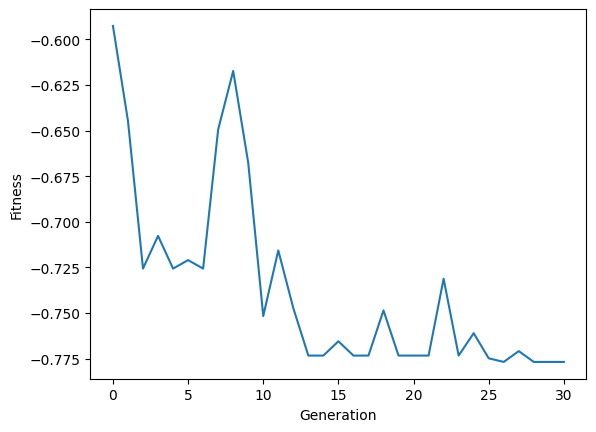

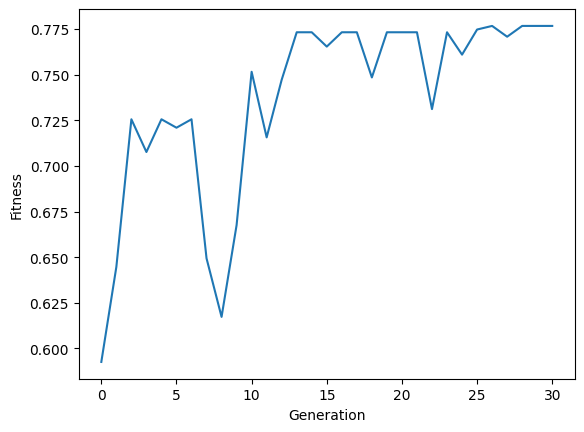

In [97]:
import matplotlib.pyplot as plt

plt.plot(avg_fitness_scores)
plt.xlabel("Generation")
plt.ylabel("Fitness")

plt.show()
avg_fitness_scores = [-x for x in avg_fitness_scores]  # 將負的 F1 分數轉換為正的(因為原始計算用負的)

plt.plot(avg_fitness_scores)
plt.xlabel("Generation")
plt.ylabel("Fitness")

plt.show()

In [25]:
from sklearn.metrics import accuracy_score

def ensemble_predict(model1, model2, dataloader):
    model1.eval()
    model2.eval()
    
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for i, data in enumerate(tqdm(dataloader)):
            sampled_text_list = [negatively_skewed_sample(text.split()) for text in data['text']]
            vectors = [text_to_vector(text) for text in sampled_text_list]
            # vectors = preProcessText_and_getVector(sampled_text_list,max_length=300)
            inputs = torch.tensor(vectors, dtype=torch.float32).to(device)
            outputs1 = model(inputs)
            outputs2 = model2(inputs)
            # _, predicted1 = torch.max(outputs1.data, 1)
            # _, predicted2 = torch.max(outputs2.data, 1)
            ensemble_outputs = (outputs1 + outputs2) / 2
            _, predicted = torch.max(ensemble_outputs.data, 1)
            _,labels = torch.max(data['label'].data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_predictions, all_labels


# 使用集成模型進行預測
predictions, labels = ensemble_predict(model, model2, test_loader)

# 計算準確度
accuracy = accuracy_score(labels, predictions)

print("Accuracy: ", accuracy)

100%|██████████| 8/8 [00:14<00:00,  1.84s/it]

Accuracy:  0.7319062181447502


In [30]:
def ensemble_predict(model1, model2, dataloader):
    model1.eval()
    model2.eval()
    
    all_predictions = []
    all_labels = []
    all_scores = []
    
    with torch.no_grad():
        for i, data in enumerate(tqdm(dataloader)):
            sampled_text_list = [negatively_skewed_sample(text.split()) for text in data['text']]
            vectors = [text_to_vector(text) for text in sampled_text_list]
            inputs = torch.tensor(vectors, dtype=torch.float32).to(device)
            outputs1 = model1(inputs)
            outputs2 = model2(inputs)
            ensemble_outputs = (outputs1 + outputs2) / 2
            _, predicted = torch.max(ensemble_outputs.data, 1)
            _,labels = torch.max(data['label'].data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(ensemble_outputs.cpu().numpy())
    # Convert lists to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_scores = np.array(all_scores)
    
    
    
    return all_predictions, all_labels, all_scores

predictions, labels, scores = ensemble_predict(model, model2, test_loader)

100%|██████████| 8/8 [00:15<00:00,  1.96s/it]


In [31]:
# Compute classification report
report = classification_report(labels, scores.argmax(axis=1))

In [33]:
print(report)

              precision    recall  f1-score   support

           0       0.90      0.81      0.85       200
           1       0.51      0.80      0.62       181
           2       0.86      0.74      0.80       200
           3       0.92      0.74      0.82       200
           4       0.57      0.53      0.55       200

    accuracy                           0.72       981
   macro avg       0.75      0.72      0.73       981
weighted avg       0.76      0.72      0.73       981



In [99]:
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=90000, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.4, inplace=False)
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=64, out_features=32, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.2, inplace=False)
  (10): Linear(in_features=32, out_features=5, bias=True)
)